In [7]:
!pip install scikit-learn pandas numpy matplotlib joblib xgboost -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os

In [9]:
DATA_PATH = "/content/final_training_dataset.csv"

df = pd.read_csv(DATA_PATH)

print("📊 Dataset loaded! Shape:", df.shape)
df.head()

📊 Dataset loaded! Shape: (1094, 6)


,Date,Gold Price (INR / 10gms),Silver Price (INR / 1kg),Price_Nifty,Price_Sensex,Impact
0,2018-01-02,26941.49638,35030.82415,"10,435.55","33,812.75",-0.22
1,2018-01-03,26793.88600,34895.83221,"10,435.55","33,812.75",-0.50
2,2018-01-04,26802.26006,34927.55533,"10,435.55","33,812.75",0.32
3,2018-01-05,26835.32914,34951.22586,"10,435.55","33,812.75",0.20
4,2018-01-06,26835.32914,34951.22586,"10,435.55","33,812.75",-0.12


In [10]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

# Fix comma values in Nifty & Sensex
df['Price_Nifty'] = pd.to_numeric(df['Price_Nifty'].astype(str).replace(",", "", regex=True))
df['Price_Sensex'] = pd.to_numeric(df['Price_Sensex'].astype(str).replace(",", "", regex=True))

df = df.fillna(method='ffill').fillna(method='bfill')

print("Columns:", df.columns.tolist())
print(df.isna().sum())

Columns: ['Date', 'Gold Price (INR / 10gms)', 'Silver Price (INR / 1kg)', 'Price_Nifty', 'Price_Sensex', 'Impact']
Date                        0
Gold Price (INR / 10gms)    0
Silver Price (INR / 1kg)    0
Price_Nifty                 0
Price_Sensex                0
Impact                      0
dtype: int64


/tmp/ipython-input-2317867251.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [11]:
price_cols = ["Gold Price (INR / 10gms)", "Silver Price (INR / 1kg)",
              "Price_Nifty", "Price_Sensex"]

# Lag features (yesterday’s values)
for col in price_cols + ["Impact"]:
    df[f"{col}_lag1"] = df[col].shift(1)

# Moving Averages (3-day, 7-day)
for col in price_cols:
    df[f"{col}_MA3"] = df[col].rolling(window=3).mean()
    df[f"{col}_MA7"] = df[col].rolling(window=7).mean()

df = df.dropna().reset_index(drop=True)
print("✅ Feature Engineering Completed")
df.head()

✅ Feature Engineering Completed


,Date,Gold Price (INR / 10gms),Silver Price (INR / 1kg),Price_Nifty,Price_Sensex,Impact,Gold Price (INR / 10gms)_lag1,Silver Price (INR / 1kg)_lag1,Price_Nifty_lag1,Price_Sensex_lag1,Impact_lag1,Gold Price (INR / 10gms)_MA3,Gold Price (INR / 10gms)_MA7,Silver Price (INR / 1kg)_MA3,Silver Price (INR / 1kg)_MA7,Price_Nifty_MA3,Price_Nifty_MA7,Price_Sensex_MA3,Price_Sensex_MA7
0,2018-01-08,26847.98670,34924.04497,10435.55,33812.75,-0.52,26835.32914,34951.22586,10435.55,33812.75,0.98,26839.548327,26841.659509,34942.165563,34947.419177,10435.55,10435.55,33812.75,33812.75
1,2018-01-09,26744.67861,34792.56245,10435.55,33812.75,-0.02,26847.98670,34924.04497,10435.55,33812.75,-0.52,26809.331483,26813.542684,34889.277760,34913.381791,10435.55,10435.55,33812.75,33812.75
2,2018-01-10,27001.16849,35057.02005,10435.55,33812.75,-0.53,26744.67861,34792.56245,10435.55,33812.75,-0.02,26864.611267,26843.154469,34924.542490,34936.408626,10435.55,10435.55,33812.75,33812.75
3,2018-01-11,27121.59897,34869.30943,10435.55,33812.75,-0.58,27001.16849,35057.02005,10435.55,33812.75,-0.53,26955.815357,26888.774313,34906.297310,34928.087783,10435.55,10435.55,33812.75,33812.75
4,2018-01-12,27160.97619,35046.42089,10435.55,33812.75,-0.12,27121.59897,34869.30943,10435.55,33812.75,-0.58,27094.581217,26935.295320,34990.916790,34941.687073,10435.55,10435.55,33812.75,33812.75


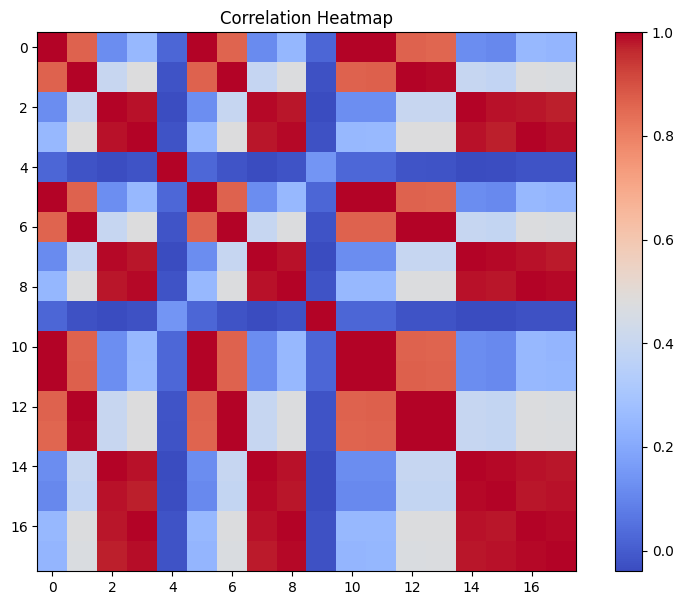

✅ Correlation matrix saved.


In [12]:
corr_matrix = df.drop(columns=["Date"]).corr()
plt.figure(figsize=(10, 7))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar()
plt.title("Correlation Heatmap")
plt.show()

os.makedirs("/content/models", exist_ok=True)
corr_matrix.to_csv("/content/models/correlation_matrix.csv", index=True)

print("✅ Correlation matrix saved.")

In [13]:
target_columns = {
    "gold": "Gold Price (INR / 10gms)",
    "silver": "Silver Price (INR / 1kg)",
    "nifty": "Price_Nifty",
    "sensex": "Price_Sensex"
}

X = df.drop(columns=["Date"] + list(target_columns.values()))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "/content/models/scaler.pkl")
print("✅ Feature Scaling Done & Scaler Saved")

✅ Feature Scaling Done & Scaler Saved


In [14]:
models = {}

for name, target in target_columns.items():
    y = df[target]

    # 90/10 Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.10, shuffle=False
    )

    # RandomForest
    model_rf = RandomForestRegressor(
        n_estimators=300, max_depth=16, random_state=42
    )
    model_rf.fit(X_train, y_train)
    pred_rf = model_rf.predict(X_test)

    # XGBoost
    model_xgb = XGBRegressor(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        random_state=42
    )
    model_xgb.fit(X_train, y_train)
    pred_xgb = model_xgb.predict(X_test)

    r2_rf = r2_score(y_test, pred_rf)
    r2_xgb = r2_score(y_test, pred_xgb)

    models[name] = model_xgb if r2_xgb > r2_rf else model_rf

    print(f"\n✅ {name.upper()} MODEL TRAINED")
    print(f"🔹 RandomForest R²: {r2_rf:.3f}")
    print(f"🔹 XGBoost R²:      {r2_xgb:.3f}")
    print(f"➡️ Selected: {'XGBoost' if r2_xgb > r2_rf else 'RandomForest'}")


✅ GOLD MODEL TRAINED
🔹 RandomForest R²: -0.034
🔹 XGBoost R²:      0.620
➡️ Selected: XGBoost

✅ SILVER MODEL TRAINED
🔹 RandomForest R²: -0.235
🔹 XGBoost R²:      -0.706
➡️ Selected: RandomForest

✅ NIFTY MODEL TRAINED
🔹 RandomForest R²: 0.378
🔹 XGBoost R²:      0.299
➡️ Selected: RandomForest

✅ SENSEX MODEL TRAINED
🔹 RandomForest R²: 0.346
🔹 XGBoost R²:      0.296
➡️ Selected: RandomForest


In [15]:
for name, model in models.items():
    joblib.dump(model, f"/content/models/{name}_price_model.pkl")

print("💾 All models saved to /content/models/")

💾 All models saved to /content/models/


In [34]:
latest_row = X_scaled[-1:]


print("\n🔮 Predicted next-day prices:")
for name, model in models.items():
    print(f"{name.capitalize()}: {model.predict(latest_row)[0]:.2f}")


🔮 Predicted next-day prices:
Gold: 44859.73
Silver: 63616.16
Nifty: 12339.32
Sensex: 41876.37


In [19]:
BACKEND_MODEL_DIR = "/content/backend/models"
os.makedirs(BACKEND_MODEL_DIR, exist_ok=True)

!cp /content/models/*.pkl $BACKEND_MODEL_DIR
!cp /content/models/correlation_matrix.csv $BACKEND_MODEL_DIR

print("🚀 Models exported to backend/models/")

🚀 Models exported to backend/models/


In [20]:
def retrain_pipeline(data_path="/content/final_training_dataset.csv"):
    """
    🔄 Retrains all asset price prediction models using latest dataset.
       Saves new models + scaler into backend/models/.
    """

    print("🚀 Retraining started...")

    # Load dataset
    df = pd.read_csv(data_path)
    print(f"📁 Loaded dataset: {df.shape}")

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # Fill missing values (forward + backward)
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Convert values to numeric (for Nifty & Sensex)
    df['Price_Nifty'] = df['Price_Nifty'].astype(str).str.replace(',', '', regex=False)
    df['Price_Sensex'] = df['Price_Sensex'].astype(str).str.replace(',', '', regex=False)
    df['Price_Nifty'] = pd.to_numeric(df['Price_Nifty'])
    df['Price_Sensex'] = pd.to_numeric(df['Price_Sensex'])

    print("✅ Cleaned and formatted dataset successfully.")

    # Feature selection
    features = ["Gold Price (INR / 10gms)", "Silver Price (INR / 1kg)", "Price_Nifty", "Price_Sensex", "Impact"]
    X = df[features]

    # Target mapping
    targets = {
        "gold": df["Gold Price (INR / 10gms)"],
        "silver": df["Silver Price (INR / 1kg)"],
        "nifty": df["Price_Nifty"],
        "sensex": df["Price_Sensex"]
    }

    # ✅ Scale using a NEW scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save scaler
    os.makedirs("/content/backend/models", exist_ok=True)
    joblib.dump(scaler, "/content/backend/models/scaler.pkl")

    print("✅ Feature scaling complete & scaler saved.")

    # Train + Save models
    for name, y in targets.items():
        print(f"🔧 Training {name.upper()} model...")

        model = RandomForestRegressor(
            n_estimators=300,   # increased for better accuracy
            max_depth=15,
            random_state=42,
            min_samples_split=2,
            min_samples_leaf=1,
        )

        model.fit(X_scaled, y)

        # Save model
        joblib.dump(model, f"/content/backend/models/{name}_price_model.pkl")

        print(f"✅ Saved updated {name.upper()} model.")

    print("\n🎉 Retraining finished — All models & scaler updated successfully!")